In [70]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Read dictionary.txt file
with open('dictionary.txt', 'r', encoding='utf-8') as f:
    data = f.readlines()

# Extract rows with "VERB" or "INFN"
verb_inf_data = []
for i, row in enumerate(data):
    if "VERB" in row or "INFN" in row:
        verb_inf_data.append(row.strip().split("\t"))

# Create pandas dataframe
df = pd.DataFrame(verb_inf_data[1:], columns=["verb", "attributes"])

# Gathering just an even 40k of the ~41k rows to make dealing with them a bit easier
df = df.sample(frac = 1).head(40000)

# Split attributes column into separate columns
df_attributes = df['attributes'].apply(lambda x: pd.Series(x.split(',')))
df_attributes.columns = ['attribute{}'.format(i) for i in range(1, len(df_attributes.columns) + 1)]

# Merge verb column with split attributes columns
df = pd.concat([df['verb'], df_attributes], axis=1)

# Fill NaN values with empty strings
df.fillna(value='', inplace=True)

# Create parallel data frame with separate columns for each attribute
parallel_df = pd.DataFrame()
for column in df_attributes.columns:
    attribute_values = df_attributes[column].unique()
    for value in attribute_values:
        parallel_df[f'{column}_{value}'] = df['verb'].where(df[column] == value, '')

# Extract the verb and attribute columns from the dataframe
verbs = df['verb']
attributes = df.iloc[:, 1:]

In [71]:
mlb = MultiLabelBinarizer()
attribute_features = mlb.fit_transform(attributes.values)
attribute_columns = mlb.classes_


In [72]:
X_train, X_test, y_train, y_test = train_test_split(verbs, attribute_features, test_size=0.2, random_state=42)


In [73]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


In [74]:
model = RandomForestClassifier(max_depth=None, random_state=0, n_jobs=-1, class_weight="balanced_subsample")
model.fit(X_train_vectorized, y_train)


RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       random_state=0)

In [75]:
y_pred = model.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8000
           1       0.86      0.63      0.73      1169
           2       0.98      0.85      0.91      1137
           3       1.00      0.77      0.87      1191
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          12       1.00      0.98      0.99       570
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         0
          16       0.71      0.12      0.20        42
          17       0.00    

/Users/finnellingwood/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/finnellingwood/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


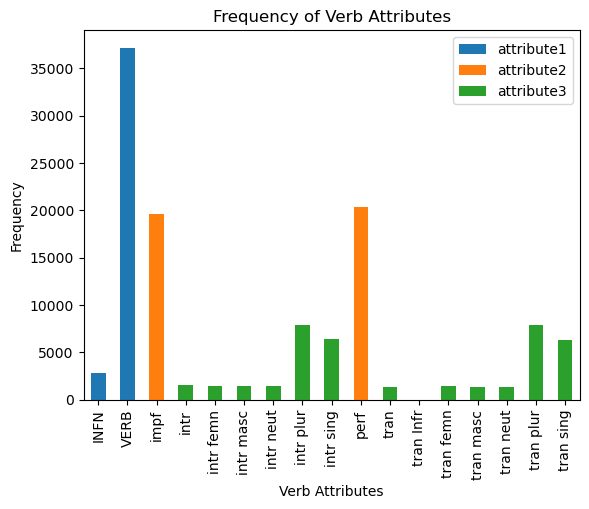

In [76]:
import matplotlib.pyplot as plt

# Filter out empty values
non_empty_attributes = attributes.replace('', np.nan).dropna(axis=1)

# Count the occurrences of each non-empty attribute
attribute_counts = non_empty_attributes.apply(pd.value_counts)

# Plot the bar chart
attribute_counts.plot(kind='bar', stacked=True)
plt.xlabel('Verb Attributes')
plt.ylabel('Frequency')
plt.title('Frequency of Verb Attributes')
plt.show()


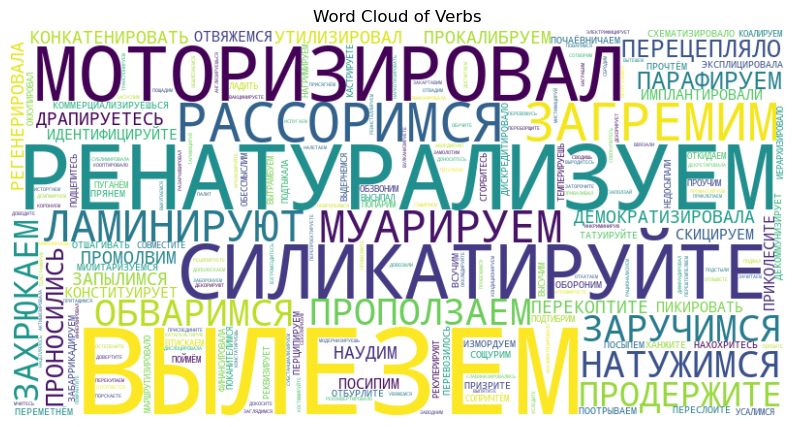

In [77]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all verbs into a single string
all_verbs = ' '.join(verbs)

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_verbs)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Verbs')
plt.show()


In [83]:
def predict_attributes(verb):
    verb_vectorized = vectorizer.transform([verb])
    predicted_attributes = model.predict(verb_vectorized)
    return mlb.inverse_transform(predicted_attributes)[0]

In [79]:
input_verb = [str(input("Enter a verb: "))]
predict_attributes(str(input_verb))

Enter a verb:  ПОСЧИТАЕТЕ


('', '2per', 'VERB', 'futr', 'indc', 'perf', 'tran plur')